# Introduction to the NeuroInformatics Platform

# Part 3: Ontology services

There are two ontology services related to the NeuroInformatics Platform, both accessible through Swagger-based web interfaces, as well as programmatically through REST services.

The first one is provided through the "Ontology Service API" developed by the NeuroInformatics Platform team of HBP. It is used to populate meta-data within the KnowledgeGraph and it can be accessed at: https://collab.humanbrainproject.eu/#/collab/47/nav/7267

The second one is the ontology developed by the Neuroscience Information Framework (NIF) team for the www.Knowledge-Space.org website. It can be accessed at: http://matrix.neuinfo.org:9000/scigraph/docs/

Both resources can be interfaced programmatically in essentially the same way (i.e., there are some small differences which make these interfaces not completely identical but very similar). To access these services, you need to used their respective root URL: <BR>
http://matrix.neuinfo.org:9000/scigraph/ <BR>
https://nip.humanbrainproject.eu/api/scigraph/
<BR>
## Before demonstrating the use of the ontology services, we define some functions that will allow us to display interesting information from the ontologies without cluttering the rest of the notebook with a lot of code.

In [1]:
import requests
import numpy as np
import pydot
import json

baseKS  = "http://matrix.neuinfo.org:9000/scigraph"
baseNIP = "https://nip.humanbrainproject.eu/api/scigraph"    

# Display json strings nicely
def jsonPrettyPrint(jsonStr):
    print json.dumps(jsonStr, sort_keys=True,
                  indent=4, separators=(',', ': '))    

    
# Build tree structures for the "part_of" relationship
# between terms fetched with the searchKey term.
#
# Arguments:
#      source : Either equal to "NIP" or "KS", depending on 
#               the ontology that need to be queried.
#      searchKey: Terms to use to search the ontology, eg. "thalam*".
#      limit : Maximum of terms that should be returned.
#
# Returned variables:
#      roots: List of terms ID (curie) for the roots of the built trees.
#      flatTrees_inv : Dictionnary indexing the trees' subject terms with
#                      the object terms with these two entities being 
#                      linked through the relationship "subject part_of object".
def computeTrees(source, searchKey, limit=1000):
    if source == "NIP":
        base     = baseNIP
        relation = "part_of"
    elif source == "KS":
        base     = baseKS
        # This URL points to the "part_of" relationship used in KS
        relation = "http://purl.obolibrary.org/obo/BFO_0000050"
    else:
        raise ValueError

    flatTrees = {}
    flatTrees_inv = {}
    responseSearch = requests.get(base + "/vocabulary/search/" + searchKey + "?limit=" + str(limit))
    concepts = responseSearch.json()
    if source == "NIP":
        concepts = concepts["concepts"]
    for item in concepts:
        if not item["deprecated"]:
            responseNeighbors = requests.get(base + "/graph/neighbors?depth=1&id=" + item["curie"])
            for edge in responseNeighbors.json()["edges"]:
                if edge["pred"] == relation: 
                    flatTrees[edge["sub"]] = edge["obj"]
                    if not edge["obj"] in flatTrees_inv:
                        flatTrees_inv[edge["obj"]] = [edge["sub"]]
                    else:
                        if not edge["sub"] in flatTrees_inv[edge["obj"]]:
                            flatTrees_inv[edge["obj"]].append(edge["sub"])
                            
    child   = np.unique(flatTrees.keys())
    parent  = np.unique(flatTrees.values())
    roots = np.array(parent)[np.logical_not(np.in1d(parent, child))]
    
    return roots, flatTrees_inv


# Build and return a dictionnary containing the names 
# of the entities contained in flatTrees_inv. This dictionnary
# is indexed by the id (curie) of the terms.
def computeNameDic(source, flatTrees_inv):
    if source == "NIP":
        base = baseNIP
    elif source == "KS":
        base = baseKS
    else:
        raise ValueError
    
    curies = flatTrees_inv.keys()
    curies.extend(np.concatenate(flatTrees_inv.values()))
    curies = np.unique(curies)

    names = {}
    for curie in curies:
        concepts = requests.get(base + "/vocabulary/id/" + curie).json()
        if source == "NIP":
            names[curie] = concepts["concepts"][0]["labels"][0]
        elif source == "KS":
            names[curie] = concepts["labels"][0]
        
    return names
        

# Print the tree structures contained in flatTrees_inv.
def printTree(roots, flatTrees_inv, names): 

    def printSubTree(invDic, root, level=0):
        print "##"*level, root, "-", names[root]
        if root in invDic:
            for child in sorted(invDic[root]):
                printSubTree(invDic, child, level+1)


    for root in roots:
        printSubTree(flatTrees_inv, root)
        print "\n\n"

        
# Save PNG images of tree graphs described in flatTrees_inv.
def saveGraphs(source, roots, flatTrees_inv, names):

    def addEdges(invDic, graph, root):
        if root in invDic:
            for child in invDic[root]:
                graph.add_edge(pydot.Edge(names[root], names[child]))
                addEdges(invDic, graph, child)

    for root in roots:
        graph = pydot.Dot(graph_type='graph')
        addEdges(flatTrees_inv, graph, root)
        graph.write_png(source + "_" + names[root] + '.png')    
        print "Saving " + source + "_" + names[root] + '.png...'        

## We can query both ontologies for a general term. For example, here, we query for thalamus-related terms using the "*" wildcard.

In [2]:
searchKey = "thalam*"

In [3]:
curiesKS  = []
response = requests.get(baseKS + "/vocabulary/search/" + searchKey + "?limit=1000")
for item in response.json():
    if not item["deprecated"]:
        print str(item["curie"]) + " ## " + str(item["labels"][0])
        curiesKS.append(item["curie"])     

SCR:014214 ## Human Thalamus in 3D Stereotactic Coordinates
NIFCELL:nlx_cell_1005003 ## Thalamus medial geniculate nucleus interneuron small
NIFCELL:nlx_cell_20081203 ## Thalamus relay cell
NIFCELL:nifext_41 ## Thalamocortical cell
NIFCELL:nifext_46 ## Thalamus interneuron small
NIFCELL:nifext_47 ## Thalamus interneuron large
NIFCELL:nifext_45 ## Thalamic reticular nucleus cell
ILX:0050015 ## Neocortex Narrow pyramidal cell projecting to thalamus
UBERON:0025261 ## thalamic fiber tract
UBERON:0013684 ## right dorsal thalamus
UBERON:0013683 ## left dorsal thalamus
MBA:1113 ## Interanterodorsal nucleus of the thalamus
MBA:1120 ## Interanteromedial nucleus of the thalamus
UBERON:0001900 ## ventral thalamus
UBERON:0001903 ## thalamic reticular nucleus
UBERON:0001925 ## ventral lateral nucleus of thalamus
UBERON:0001920 ## paraventricular nucleus of thalamus
MBA:1020 ## Posterior complex of the thalamus
MBA:1029 ## Posterior limiting nucleus of the thalamus
MBA:1008 ## Geniculate group, dors

In [4]:
response = requests.get(baseNIP + "/vocabulary/search/" + searchKey + "?limit=10000")
curiesNIP = []
# Notice here the slight difference in the interface, in that with KS
# we were directy using "for item in sg.get_response().json():"
# with NIP, we must first get the "concepts" key of the root element.
for item in response.json()["concepts"]:
    if not item["deprecated"]:
        print str(item["curie"]) + " ## " + str(item["labels"][0])
        curiesNIP.append(item["curie"])

MBA:1068 ## dorsal thalamus related
MBA:239 ## Anterior group of the dorsal thalamus
MBA:637 ## Ventral group of the dorsal thalamus
MBA:444 ## Medial group of the dorsal thalamus
MBA:262 ## Reticular nucleus of the thalamus
MBA:896 ## thalamus related
MBA:255 ## Anteroventral nucleus of thalamus
MBA:629 ## Ventral anterior-lateral complex of the thalamus
MBA:626 ## Mediodorsal nucleus of the thalamus, lateral part
MBA:86 ## middle thalamic commissure
MBA:636 ## Mediodorsal nucleus of the thalamus, medial part
MBA:709 ## Ventral posterior complex of the thalamus
MBA:218 ## Lateral posterior nucleus of the thalamus
MBA:617 ## Mediodorsal nucleus of the thalamus, central part
MBA:864 ## Thalamus, sensory-motor cortex related
MBA:1113 ## Interanterodorsal nucleus of the thalamus
MBA:1120 ## Interanteromedial nucleus of the thalamus
MBA:856 ## Thalamus, polymodal association cortex related
MBA:1014 ## Geniculate group, ventral thalamus
MBA:685 ## Ventral medial nucleus of the thalamus
MBA:

## We can further check how much the set of terms defined in these two ontologies overlap. Here, we show that for the "thalam*" query, among the 235 terms defined in the two ontologies, only 17.8% are defined in both ontologies.

In [5]:
import numpy as np
curiesCommon  = np.array(curiesKS)[np.in1d(curiesKS, curiesNIP)]
curiesKSOnly  = np.array(curiesKS)[np.logical_not(np.in1d(curiesKS, curiesNIP))]
curiesNIPOnly = np.array(curiesNIP)[np.logical_not(np.in1d(curiesNIP, curiesKS))]

In [21]:
print "Number of terms in common in both ontologies: ", len(curiesCommon)
print "Number of terms included in KnowledgeSpace but not the NIP:", len(curiesKSOnly)
print "Number of terms included in NIP but not in KnowledgeSpace:", len(curiesNIPOnly)
print " "

nbDistinctTerms = len(curiesCommon) + len(curiesKSOnly) + len(curiesNIPOnly)
print "Thus, on a total of " + str(nbDistinctTerms) \
    + " distinct ontological terms about the thalamus, only "  \
    + str(float(len(curiesCommon))/nbDistinctTerms*100.0) \
    + "%"
print "are shared between the two ontologies."



Number of terms in common in both ontologies:  42
Number of terms included in KnowledgeSpace but not the NIP: 89
Number of terms included in NIP but not in KnowledgeSpace: 104
 
Thus, on a total of 235 distinct ontological terms about the thalamus, only 17.8723404255%
are shared between the two ontologies.


## We can list the types of relationship available in each ontologies... 

In [24]:
response = requests.get(baseNIP + "/graph/relationship_types")
print "Relationships available in the KnowledgeGraph (NIP) ontology:"
for relationship in response.json():
    print "\t- " + relationship


Relationships available in the KnowledgeGraph (NIP) ontology:
	- equivalentClass
	- filler
	- has_domain_aspect
	- has_rank
	- isDefinedBy
	- is_smaller_than
	- legalcode
	- part_of
	- property
	- seeAlso
	- subClassOf


In [26]:
response = requests.get(baseKS + "/graph/relationship_types")
print "Relationships available in the KnowledgeSpace (KS) ontology:"
for relationship in response.json():
    print "\t- " + relationship


Relationships available in the KnowledgeSpace (KS) ontology:
	- class
	- differentFrom
	- equivalentClass
	- filler
	- http://ontology.neuinfo.org/NIF/Backend/BIRNLex-OBO-UBO.owl#birnlex_17
	- http://ontology.neuinfo.org/NIF/Backend/OBO_annotation_properties.owl#synonym
	- http://ontology.neuinfo.org/NIF/BiomaterialEntities/NIF-GrossAnatomy.owl#has_lacking_of
	- http://ontology.neuinfo.org/NIF/BiomaterialEntities/NIF-Neuron-NT-Bridge.owl#has_molecular_constituent
	- http://ontology.neuinfo.org/NIF/BiomaterialEntities/NIF-Neuron-NT-Bridge.owl#has_neurotransmitter
	- http://ontology.neuinfo.org/NIF/BiomaterialEntities/NIF-Neuron-NT-Bridge.owl#soma_located_in
	- http://purl.bioontology.org/NEMO/ontology/NEMO.owl#NEMO_0000035
	- http://purl.bioontology.org/NEMO/ontology/NEMO.owl#NEMO_0367000
	- http://purl.bioontology.org/NEMO/ontology/NEMO.owl#NEMO_1568000
	- http://purl.bioontology.org/NEMO/ontology/NEMO.owl#NEMO_2317000
	- http://purl.bioontology.org/NEMO/ontology/NEMO.owl#NEMO_2532000


## As can be seen, much more relationships are used in the KS ontology, with some of these being defined by URI which are not directly indicative of the nature of the relationship. Following these URI, we can get the complete information about these relationships. As a reference, the corresponding names of these relationships is listed in the following dictionnary:

In [27]:
relationLabels = \
    {"equivalentClass"              : "equivalentClass",
     "is_bearer_of"                 : "http://ontology.neuinfo.org/NIF/Backend/BIRNLex-OBO-UBO.owl#birnlex_17",
     "has_neurotransmitter"         : "http://ontology.neuinfo.org/NIF/BiomaterialEntities/NIF-Neuron-NT-Bridge.owl#has_neurotransmitter",
     "part_of"                      : "http://purl.obolibrary.org/obo/BFO_0000050",
     "in_left_side_of"              : "http://purl.obolibrary.org/obo/BSPO_0000120",
     "in_right_side_of"             : "http://purl.obolibrary.org/obo/BSPO_0000121",
     "in_lateral_side_of"           : "http://purl.obolibrary.org/obo/BSPO_0000126",
     "continuous_with"              : "http://purl.obolibrary.org/obo/RO_0002150",
     "present_in_taxon"             : "http://purl.obolibrary.org/obo/RO_0002175",
     "adjacent_to"                  : "http://purl.obolibrary.org/obo/RO_0002220",
     "contributes_to_morphology_of" : "http://purl.obolibrary.org/obo/RO_0002433",
     "hasDbXref"                    : "http://www.geneontology.org/formats/oboInOwl#hasDbXref",
     "inSubset"                     : "http://www.geneontology.org/formats/oboInOwl#inSubset",
     "has_proper_part"              : "http://www.obofoundry.org/ro/ro.owl#has_proper_part",
     "proper_part_of"               : "http://www.obofoundry.org/ro/ro.owl#proper_part_of",
     "depicted_by"                  : "http://xmlns.com/foaf/0.1/depicted_by",
     "isDefinedBy"                  : "isDefinedBy",
     "subClassOf"                   : "subClassOf"}

## Next, we build trees for the relationship "part_of" linking the different terms fetched by the "thalam*" queries. We save PNG images of these graphs. However, we rather print the text version of these graphs here since it is more easily displayable in a notebook.

In [28]:
rootsNIP, flatTrees_invNIP = computeTrees("NIP", "thalam*")
rootsKS,  flatTrees_invKS  = computeTrees("KS" , "thalam*")

In [29]:
namesNIP = computeNameDic("NIP", flatTrees_invNIP)
namesKS  = computeNameDic("KS",  flatTrees_invKS)

In [30]:
import os
if os.system('which dot') == 0:
    saveGraphs("NIP", rootsNIP, flatTrees_invNIP, namesNIP)
else: 
    print "The dot program is not installed on this computer. Skipping this step."


Saving NIP_diencephalon.png...
Saving NIP_anterior group of nuclei, left.png...
Saving NIP_medial group of nuclei, left.png...
Saving NIP_lateral group of nuclei, left, dorsal division.png...
Saving NIP_lateral group of nuclei, left, ventral division.png...
Saving NIP_posterior group of nuclei, left.png...
Saving NIP_rostral group of intralaminar nuclei, left.png...
Saving NIP_caudal group of intralaminar nuclei, left.png...
Saving NIP_anterior group of nuclei, right.png...
Saving NIP_medial group of nuclei, right.png...
Saving NIP_lateral group of nuclei, right, dorsal division.png...
Saving NIP_lateral group of nuclei, right, ventral division.png...
Saving NIP_posterior group of nuclei, right.png...
Saving NIP_rostral group of intralaminar nuclei, right.png...
Saving NIP_caudal group of intralaminar nuclei, right.png...
Saving NIP_epithalamus.png...
Saving NIP_telencephalic white matter tracts.png...
Saving NIP_White matter.png...
Saving NIP_Gray matter.png...
Saving NIP_Interbrain.p

In [31]:
if os.system('which dot') == 0:
    saveGraphs("KS", rootsKS, flatTrees_invKS, namesKS)
else: 
    print "The dot program is not installed on this computer. Skipping this step."


Saving KS_diencephalon development.png...
Saving KS_Interbrain.png...
Saving KS_hypothalamus related.png...
Saving KS_lateral forebrain bundle system.png...
Saving KS_diencephalon.png...
Saving KS_rostral intralaminar nuclear group.png...
Saving KS_anterior limb of internal capsule.png...
Saving KS_forebrain ipsilateral fiber tracts.png...
Saving KS_retrolenticular part of internal capsule.png...


In [32]:
printTree(rootsNIP, flatTrees_invNIP, namesNIP)

 HBA:4391 - diencephalon
## HBA:4392 - thalamus
#### HBA:4393 - dorsal thalamus
###### HBA:12920 - anterior group of nuclei
###### HBA:12921 - caudal group of intralaminar nuclei
###### HBA:12922 - dorsal lateral geneiculate nucleus
###### HBA:12923 - lateral group of nuclei
###### HBA:12926 - medial geniculate complex
###### HBA:12927 - medial group of nuclei
###### HBA:12928 - posterior group of nuclei
###### HBA:12929 - rostral group of intralaminar nuclei
#### HBA:4504 - ventral thalamus
###### HBA:4505 - ventral thalamus, left
######## HBA:4506 - reticular nucleus of thalamus, left
######## HBA:4507 - zona incerta, left
######## HBA:4508 - nucleus of the H field of Forel, left
###### HBA:4511 - ventral thalamus, right
######## HBA:4512 - reticular nucleus of thalamus, right
######## HBA:4513 - zona incerta, right
######## HBA:4514 - nucleus of the H field of Forel, right



 HBA:4395 - anterior group of nuclei, left
## HBA:4396 - anteromedial nucleus of the thalamus, left
## HBA:4

In [33]:
printTree(rootsKS, flatTrees_invKS, namesKS)

 GO:0021536 - diencephalon development
## GO:0021794 - thalamus development
#### GO:0021771 - lateral geniculate nucleus development



 MBA:1129 - Interbrain
## MBA:549 - Thalamus
#### MBA:856 - Thalamus, polymodal association cortex related
###### MBA:1014 - Geniculate group, ventral thalamus
######## MBA:178 - Ventral part of the lateral geniculate complex
######## MBA:27 - Intergeniculate leaflet of the lateral geniculate complex
######## MBA:321 - Subgeniculate nucleus
###### MBA:138 - Lateral group of the dorsal thalamus
######## MBA:1020 - Posterior complex of the thalamus
######## MBA:1029 - Posterior limiting nucleus of the thalamus
######## MBA:218 - Lateral posterior nucleus of the thalamus
######## MBA:325 - Suprageniculate nucleus
###### MBA:239 - Anterior group of the dorsal thalamus
######## MBA:1113 - Interanterodorsal nucleus of the thalamus
######## MBA:1120 - Interanteromedial nucleus of the thalamus
######## MBA:127 - Anteromedial nucleus
######## MBA:155 - Lateral 

## Comparing these two sets of trees, we can observe that the terms shared between KS and NIP form a single tree with the term "MBA:1129":"Interbrain" as its root. Indeed, both ontology services import the ontological terms defined in the mouse brain atlas (MBA) of the Alan Brain Institute. Thus, interestingly, resources associated with these terms will be linkable to ressources available both in KnowledgeSpace and the rest of the NeuroInformatics Platform, such as the atlas services, the KnowledgeGraph, and the DataSpace.

## We can further visualize this tree as a graph...

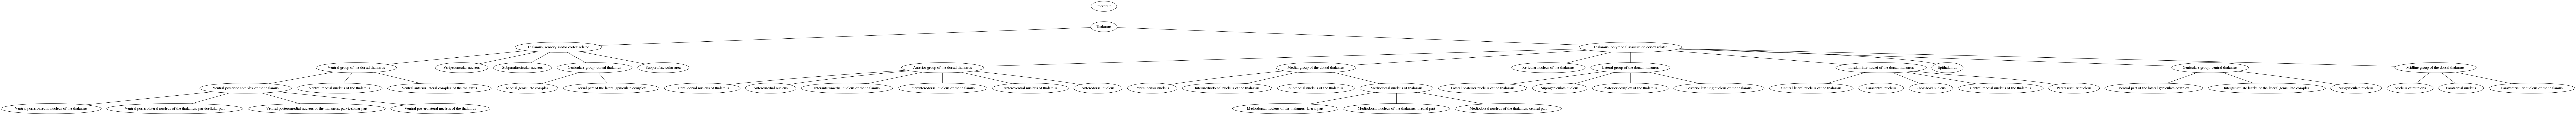

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display

if os.system('which dot') == 0:
    display(Image(filename="NIP_" + namesNIP["MBA:1129"] + '.png', width="800%", embed=True, unconfined=True))
else: 
    print "The dot program is not installed on this computer. Skipping this step."


## ... and, for example, query one of its terms and display its full JSON representation.

In [17]:
term = "Ventral posterolateral nucleus of the thalamus"
response = requests.get(baseNIP + "/vocabulary/term/" + term)
jsonPrettyPrint(response.json())

{
    "concepts": [
        {
            "abbreviations": [],
            "acronyms": [],
            "categories": [],
            "curie": "MBA:718",
            "definitions": [],
            "deprecated": false,
            "fragment": "718",
            "labels": [
                "Ventral posterolateral nucleus of the thalamus"
            ],
            "synonyms": [
                "VPL"
            ],
            "uri": "http://api.brain-map.org/api/v2/data/Structure/718"
        }
    ]
}
